In [2]:
import xarray as xr
import netCDF4 as nc
import numpy as np
from scipy.io import netcdf

import dash
import dash_core_components as dcc
import dash_html_components as html

import matplotlib
from __future__ import print_function
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.animation as anim
import cartopy
from IPython.display import HTML
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import unregister_cmap
import os
import ecrlisca.environment
import glob
import time

In [3]:
class Experiment:
    def __init__(self,multiplier=1,land_year='0Ma'):
        self.multiplier = multiplier
        self.land_year = land_year
        self.path_format = f'variable_co2_{self.multiplier}x_continents_{self.land_year}_experiment'
        self.file_path = os.path.join(os.environ.get('GFDL_DATA'),self.path_format)
        self.files = sorted(glob.glob(os.path.join(self.file_path,'run*/atmos_monthly.nc')))
        self.land_file = os.path.join(os.environ.get('ISCA_REPO_DIR'),f'experiments/input/land_masks/continents_{self.land_year}.nc') 
        

In [5]:
exp = Experiment(multiplier=2,land_year=0)

In [6]:
def define_land_colormap():

    ncolors = 256
    color_array = plt.get_cmap('gray')(range(ncolors))[::-1]

    # change alpha values
    #color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
    #color_array[-1,-1] = 1.0

    map_object = LinearSegmentedColormap.from_list(name='land_cmap',colors=color_array)

    # register this new colormap with matplotlib
    unregister_cmap('land_cmap')
    plt.register_cmap(cmap=map_object)
    
define_land_colormap()    

In [7]:
def get_data(experiment,field='t_surf',level=None,decode_times=True):
    data = xr.open_mfdataset(experiment.files,decode_times=decode_times)
    land = xr.open_mfdataset(experiment.land_file,decode_times=decode_times)
    
    if 'co2' in data:
        tmp = data[[field,'co2']]
    else:
        tmp = data[[field]]
    
    tmp['land_mask'] = (land['land_mask'].dims,land['land_mask'].values)

    if 'pfull' in tmp[field].dims:
        if level is None:
            level = 250
        levels = np.array(tmp['pfull'].values)
        level = levels[np.argmin(np.abs(levels-level))]
        
        tmp[field] = tmp[field].sel(pfull = level)
    
    return tmp


In [8]:
def get_avg_field(data,field='t_surf',vmin=None,vmax=None):

    land = data['land_mask']
# Setup the initial plot
    if 'co2' in data:
        co2 = data['co2']

    variable = data[field]    

    lons = sorted(variable.lon.values)  

    fig = plt.figure(figsize=(10,5))
    proj = ccrs.PlateCarree(central_longitude=180.0)
    ax = plt.axes(projection=proj)

    if 'time' in variable.dims:
        avg = variable.mean(dim='time')
    else:
        avg = variable   
    
    image = avg.plot.imshow(ax=ax, transform=proj, 
                            interpolation='bilinear',cmap="coolwarm", 
                            animated=True, add_colorbar=False,
                            )
    
    if land is not None:
        land_img = land.plot.contour(ax=ax, transform=ccrs.PlateCarree(), 
                                     cmap="land_cmap", 
                                     add_colorbar=False,
                                     alpha=1.0,
                                    )
    else:
        ax.coastlines()
    

    try:
        cb = plt.colorbar(image, ax=ax, orientation='horizontal', pad=0.05, label=f'{variable.long_name} ({variable.units})')
    except:
        cb = plt.colorbar(image, ax=ax, orientation='horizontal', pad=0.05, label=f'{variable.name}')
    
    if vmin is None or vmax is None:
        image.set_clim(variable.values.min(),variable.values.max())
    else:
        image.set_clim(vmin,vmax)
        
    text = cb.ax.xaxis.label
    font = matplotlib.font_manager.FontProperties(size=16)
    text.set_font_properties(font)
    
    image.set_array(avg.sel(lon=lons))
    
    if 'co2' in data:
        ax.set_title(f'Time Average, CO2 = {round(co2.values.mean())} ({co2.units})',fontsize=20)
    else:
        ax.set_title(f'Time Average',fontsize=20)

In [9]:
def get_animation(exp,field='t_surf',level=None,vmin=None,vmax=None):

    data = get_data(exp,field=field,level=level,decode_times=True)
    
    land = data['land_mask']
# Setup the initial plot
    if 'co2' in data:
        co2 = data['co2']

    variable = data[field]

    fig = plt.figure(figsize=(12,7))
    proj = ccrs.PlateCarree(central_longitude=180.0)
    ax = plt.axes(projection=proj)

    image = variable.mean(dim='time').plot.imshow(ax=ax, transform=proj, 
                                                  interpolation='bilinear',cmap="coolwarm", 
                                                  animated=True, add_colorbar=False)
    
    
    if land is not None:
        land_img = land.plot.contour(ax=ax, transform=ccrs.PlateCarree(), 
                                     cmap="land_cmap", 
                                     add_colorbar=False,
                                     alpha=1.0,
                                    )
    else:
        ax.coastlines()
    
    
    try:
        cb = plt.colorbar(image, ax=ax, orientation='horizontal', pad=0.05, label=f'{variable.long_name} ({variable.units})')
    except:
        cb = plt.colorbar(image, ax=ax, orientation='horizontal', pad=0.05, label=f'{variable.name}')
    
    if vmin is None or vmax is None:
        image.set_clim(variable.values.min(),variable.values.max())
    else:
        image.set_clim(vmin,vmax)
        
    text = cb.ax.xaxis.label
    font = matplotlib.font_manager.FontProperties(size=16)
    text.set_font_properties(font)
    
    def update(i):
        t = variable.time.values[i]
        if 'co2' in data:
            ax.set_title(f'time = {t.strftime("%B %Y")}, co2 = {round(co2.values[i][0])} ({co2.units})',fontsize=20)
        else:
            ax.set_title(f'time = {t.strftime("%B %Y")}',fontsize=20)
            
        image.set_array(variable.sel(time=t))
        return image
    
    plt.close()
    animation = anim.FuncAnimation(fig, update, frames=range(len(variable.time)), blit=False)
    writervideo = anim.FFMpegWriter(fps=1) 
    anim_file = os.path.join(os.environ.get('ISCA_REPO_DIR'),f'postprocessing/anims/{exp.path_format}_{field}.mp4')
    animation.save(anim_file, writer=writervideo)
    return HTML(animation.to_jshtml())

In [319]:
fig = get_animation(Experiment(multiplier=4,land_year=0),field='sphum',vmin=1.8e-06,vmax=0.00325)

/data/team/conda/envs/isca_post/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning:

Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range



In [311]:
tmp = get_data(Experiment(multiplier=1,land_year=0),field='sphum')

/data/team/conda/envs/isca_post/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning:

Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range



In [315]:
tmp['sphum'].values.max()

0.0032428515

In [293]:
tmp

<xarray.Dataset>
Dimensions:      (time: 60, pfull: 25, lat: 64, lon: 128, scalar_axis: 1)
Coordinates:
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * time         (time) object 0001-01-16 00:00:00 ... 0005-12-16 00:00:00
  * pfull        (pfull) float64 4.329 15.55 25.36 39.73 ... 970.2 983.8 994.9
  * scalar_axis  (scalar_axis) float64 0.0
Data variables:
    vor          (time, pfull, lat, lon) float32 dask.array<chunksize=(1, 25, 64, 128), meta=np.ndarray>
    co2          (time, scalar_axis) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    land_mask    (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    filename:   /data/bnb32/gfdl_work/experiment/variable_co2_1x_continents_0...
    title:      FMS Model results
    grid_type:  regular
    grid_tile:  N/A

In [308]:
tmp['vor'].values.max()

7.581669e-05

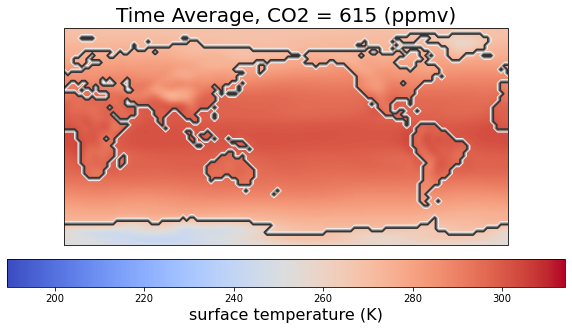

In [105]:
get_avg_field(data)

In [116]:
files = ['/home/ec2-user/environment/isca_aws/experiments/input/land_masks/era_land_t42.nc']
data = get_data(files,'zsurf',None,exp=None)

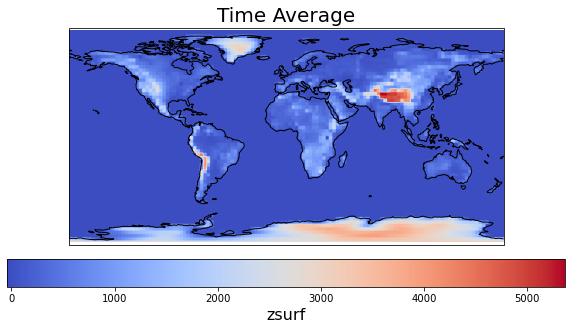

In [134]:
get_avg_field(data,exp=None)

In [12]:
import flask
import dash
import dash_core_components as dcc
import dash_html_components as html
import os
import time

server = flask.Flask(__name__)
app = dash.Dash(__name__, server=server)


files = [f for f in os.listdir('./anims/')]# if os.path.isfile(os.path.join('./anims/', f))]

app.layout = html.Div([
    html.Div(
        [html.H2('Choose Animation:',style={'textAlign':'center'})]
    ),
    dcc.Dropdown(id='filename',
                 options=[
                     {'label': i, 'value': i} for i in files
                 ],
                 multi=False,
                 placeholder='Select an animation',
                 style={'width':'100%','font-size':'20px','align-items':'center','justify-content':'center'}
                 ),
    html.Div([
        html.Div([],id='animation'),
    ], style={'textAlign':'center'})
    
])


@app.callback(
    [dash.dependencies.Output(component_id='animation',component_property='children')],
    [dash.dependencies.Input(component_id='filename', component_property='value')],
    [dash.dependencies.State('animation','children')])

def update_output(filename,children):
    
    path = f'/anims/{filename}'
    while filename == None:
        time.sleep(0.1)
    
    return [html.Video(src=path, controls=True)]

@server.route('/anims/<path:path>')
def serve_static(path):
    root_dir = os.getcwd()
    return flask.send_from_directory(os.path.join(root_dir, 'anims'), path)

app.run_server(host='localhost',debug=False,use_reloader=False,port=8050)
#app.run_server(debug=True, host='localhost', port=8050, use_reloader=False)

Dash is running on http://localhost:8050/

Dash is running on http://localhost:8050/

Dash is running on http://localhost:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://localhost:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [14/Sep/2021 14:52:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2021 14:52:56] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2021 14:52:56] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2021 14:52:57] "GET /_dash-component-suites/dash_core_components/async-dropdown.js HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2021 14:53:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2021 14:53:02] "GET /anims/variable_co2_1x_continents_0Ma_experiment_t_surf.mp4 HTTP/1.1" 206 -
127.0.0.1 - - [14/Sep/2021 14:53:02] "GET /anims/variable_co2_1x_continents_0Ma_experiment_t_surf.mp4 HTTP/1.1" 206 -
127.0.0.1 - - [14/Sep/2021 14:53:03] "GET /anims/variable_co2_1x_continents_0Ma_experiment_t_surf.mp4 HTTP/1.1" 206 -
127.0.0.1 - - [14/Sep/2021 14:53:07] "GET /anims/variable_co2_1x_continents_0Ma_experiment_t_surf.mp4 HTTP/1.1" 206 -
127.0.0.1 - - [14/Sep/2021 15:28:54] "GET / HTTP/1.1" 

In [45]:
data = xr.open_mfdataset('../../experiments/input/co2_1x_continents_10Ma.nc',decode_times=False)

In [44]:
!pwd

/home/ec2-user/environment/isca_aws/ecrlisca/postprocessing


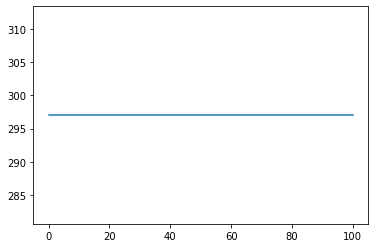

In [46]:
plt.plot(data['co2'].values[:,0,:,0])
#plt.plot(data['co2'].values[:,1,0,0])

In [13]:
data['co2'].values[0,0,:,0]

array([300.], dtype=float32)

In [7]:
!pwd

/home/ec2-user/environment/isca_aws/ecrlisca/postprocessing


In [21]:
f = open('../data/co2.txt','r')

In [22]:
lines = f.readlines()

In [23]:
lines = [l.strip('\n').split() for l in lines]

In [24]:
lines = {-int(l[0]): float(l[1])*300.0 for l in lines}
lines

{570: 3511.0860000000002,
 560: 4880.052,
 550: 5385.441,
 540: 5158.146,
 530: 7658.1179999999995,
 520: 7854.666,
 510: 6719.175,
 500: 5667.567,
 490: 5189.025,
 480: 5185.071,
 470: 5317.866,
 460: 4640.829,
 450: 4756.338,
 440: 5005.7970000000005,
 430: 5099.268,
 420: 4170.522,
 410: 3311.61,
 400: 3396.855,
 390: 4036.365,
 380: 4590.6630000000005,
 370: 2412.0051000000003,
 360: 1841.3889,
 350: 1301.2707,
 340: 811.4901,
 330: 501.4299,
 320: 401.42040000000003,
 310: 376.2249,
 300: 374.9928,
 290: 397.8864,
 280: 376.60530000000006,
 270: 432.1767,
 260: 561.6966,
 250: 1824.5649,
 240: 2131.2426,
 230: 1559.2097999999999,
 220: 1749.3935999999999,
 210: 1473.7023,
 200: 1632.6375,
 190: 1332.4488,
 180: 1453.1907,
 170: 2572.0442999999996,
 160: 2737.1325,
 150: 2279.7915000000003,
 140: 2459.5632,
 130: 1981.7604000000001,
 120: 1829.0862,
 110: 1766.616,
 100: 1590.309,
 90: 1295.3517000000002,
 80: 1255.5291,
 70: 960.0153,
 60: 840.6432000000001,
 50: 953.0927999999999

In [25]:
lines[0]

296.39103

In [43]:
f = open('../data/co2.py','w')
f.write('series = ')

9

In [32]:
import json

In [36]:
f.write('series='+json.dumps(lines))

1152

In [34]:
!pwd

/home/ec2-user/environment/isca_aws/ecrlisca/postprocessing


In [37]:
f.write('series=')

7

In [42]:
json.dump(lines,f)

In [50]:
1/(1+0.4*(0.55)/4.7)

0.9552845528455285

In [58]:
a = {3:2,1:4}

b = sorted(a)

In [59]:
b

[1, 3]

In [41]:
from ecrlisca.preprocessing.utils import adjust_continents,interpolate_land,get_original_map_data,adjust_co2,interpolate_co2,land_years
from ecrlisca.data.co2 import series as co2series

In [2]:
tmp = adjust_continents("22Ma")

/home/ec2-user/environment/isca_aws/experiments/input/land_masks/continents_22Ma.nc


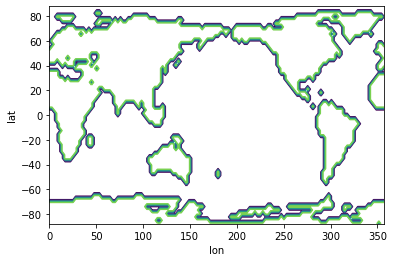

In [3]:
tmp['land_mask'].plot.contour()

In [2]:
adjust_co2(land_year="22Ma")

In [6]:
'22'.strip('Ma')

'22'

In [9]:
keys = sorted([float(k) for k in co2series.keys()])

In [10]:
keys

[0.0,
 10.0,
 20.0,
 30.0,
 40.0,
 50.0,
 60.0,
 70.0,
 80.0,
 90.0,
 100.0,
 110.0,
 120.0,
 130.0,
 140.0,
 150.0,
 160.0,
 170.0,
 180.0,
 190.0,
 200.0,
 210.0,
 220.0,
 230.0,
 240.0,
 250.0,
 260.0,
 270.0,
 280.0,
 290.0,
 300.0,
 310.0,
 320.0,
 330.0,
 340.0,
 350.0,
 360.0,
 370.0,
 380.0,
 390.0,
 400.0,
 410.0,
 420.0,
 430.0,
 440.0,
 450.0,
 460.0,
 470.0,
 480.0,
 490.0,
 500.0,
 510.0,
 520.0,
 530.0,
 540.0,
 550.0,
 560.0,
 570.0]

In [45]:
import xarray as xr
from ecrlisca.preprocessing.utils import regrid_continent_data
import glob
import numpy as np
file = glob.glob('../../experiments/input/land_masks/raw/Map*_10Ma.nc')
land = xr.open_mfdataset(file,decode_times=False)
tmp = land['z'].values
tmp[tmp<-40]=0
land['land_mask'] = (land['z'].dims,np.array(tmp>0,dtype=float))
#land = regrid_continent_data(land,land_year=10)

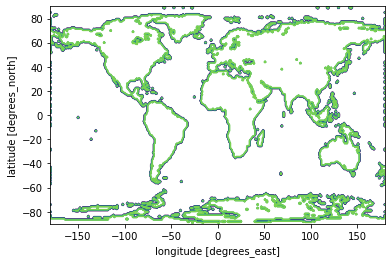

In [46]:
land['land_mask'].plot.contour()

In [46]:
tmp = np.zeros(land['z'].values.shape)
tmp = land['z'].values
tmp[tmp<0]=0
land['z'] = (land['z'].dims,tmp)

In [47]:
import xesmf as xe

base = xr.open_mfdataset(os.environ.get('BASE_TOPO_FILE'))
 
ds_out = xr.Dataset({'lat': (['lat'], base['lat'].values),
                     'lon': (['lon'], base['lon'].values)})

regridder = xe.Regridder(land, ds_out, 'bilinear')
ds_out = regridder(land)
ds_out['land_mask'] = (ds_out['z'].dims,np.array(ds_out['z'].values > 0.0,dtype=float))

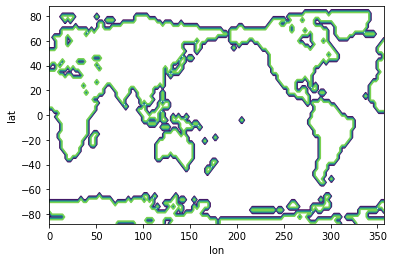

In [48]:
ds_out['land_mask'].plot.contour()

In [23]:
land = xr.open_mfdataset('../../experiments/input/land_masks/continents_55Ma.nc',decode_times=False)

NameError: name 'xr' is not defined

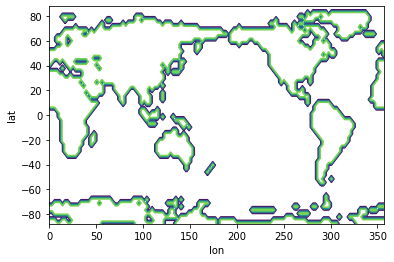

In [44]:
land['land_mask'].plot.contour()

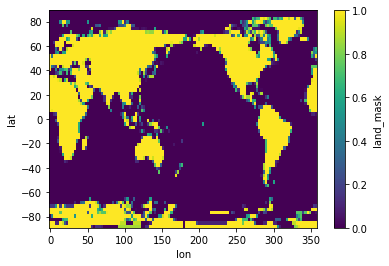

In [40]:
ds_out['land_mask'].plot.imshow()

In [34]:
!pwd

/home/ec2-user/environment/isca_aws/ecrlisca/postprocessing


In [40]:
tmp['co2'].values.mean()

514.4144

In [28]:
tmp['co2'].units

'ppmv'

In [8]:
from ecrlisca.preprocessing.utils import interpolate_co2

In [26]:
val = interpolate_co2('500Ma')

In [27]:
val

5667.567

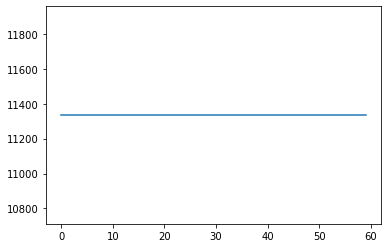

In [32]:
plt.plot(tmp['co2'])

In [42]:
land = get_original_map_data('55Ma')

OSError: no files to open

In [43]:
import ecrlisca.environment

In [45]:
file = glob.glob(os.environ.get("RAW_TOPO_DIR")+'/Map*_55Ma.nc')

In [46]:
file

['/home/ec2-user/environment/isca_aws/experiments/input/land_masks/raw/Map14_PALEOMAP_1deg_Paleocene_Eocene_Boundary_55Ma.nc']

In [10]:
from ecrlisca.data.co2 import series as co2series

In [12]:
co2series['5']

KeyError: '5'

In [1]:
from ecrlisca.preprocessing.utils import interpolate_co2

In [6]:
interpolate_co2(10.0)

297.0339

In [12]:
from ecrlisca.data.co2 import series

In [18]:
series[50.0]

953.0927999999999

In [15]:
keys = sorted(series)

In [16]:
kf = [float(k) for k in keys]

In [19]:
str(1.0)

'1.0'

SyntaxError: cannot assign to literal (3542556914.py, line 1)

In [11]:
series[0.0]

NameError: name 'series' is not defined

In [22]:
20000/10**6

0.02

In [82]:
from ecrlisca.experiment import Experiment
tmp = xr.open_mfdataset(Experiment(land_year=55).files)

In [83]:
tmp = tmp['t_surf'].mean(dim=['lat','lon'])

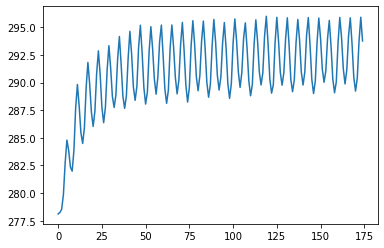

In [84]:
import matplotlib.pyplot as plt
plt.plot(tmp)